# Fine-tune Donut 🍩 on SROIE

In this notebook, we'll fine-tune Donut (which is an instance of VisionEncoderDecoderModel). We will use the SROIE dataset a collection of 1000 scanned receipts, including their OCR. More information for the dataset can be found at the repository.



## Setting Up the Environment

Our first step is to install the Hugging Face Libraries, including transformers and datasets. Running the following cell will install all the required packages.

In [2]:
%%capture
!pip install transformers datasets sentencepiece tensorboard
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

This example will use the Hugging Face Hub as a remote model versioning service. To be able to push our model to the Hub, you need to register on the Hugging Face. If you already have an account, you can skip this step. After you have an account, we will use the notebook_login util from the huggingface_hub package to log into our account and store our token (access key) on the disk.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Load SROIE dataset


We will use the [SROIE](https://github.com/zzzDavid/ICDAR-2019-SROIE) dataset a collection of 1000 scanned receipts including their OCR, more specifically we will use the dataset from task 2 "Scanned Receipt OCR". The available dataset on Hugging Face ([darentang/sroie](darentang/sroie)) is not compatible with Donut. Thats why we will use the original dataset together with the `imagefolder` feature of `datasets` to load our dataset. Learn more about loading image data [here](https://huggingface.co/docs/datasets/v2.4.0/en/image_load#load-image-data).

*Note: The test data for task2 is sadly not available. Meaning that we end up only with 624 images.*

First, we will clone the repository, extract the dataset into a separate folder and remove the unnecessary files.

In [4]:
# clone repository
!git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data
!cp -r ICDAR-2019-SROIE/data ./
# clean up
!rm -rf ICDAR-2019-SROIE
!rm -rf data/box

Cloning into 'ICDAR-2019-SROIE'...
remote: Enumerating objects: 2386, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2386 (delta 18), reused 18 (delta 18), pack-reused 2366
Receiving objects: 100% (2386/2386), 278.64 MiB | 31.60 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (1980/1980), done.


Now we have two folders inside the `data/` directory. One contains the images of the receipts and the other contains the OCR text. The nex step is to create a `metadata.json` file that contains the information about the images including the OCR-text. This is necessary for the `imagefolder` feature of `datasets`.

The `metadata.json` should look at the end similar to the example below.

```
{"file_name": "0001.png", "text": "This is a golden retriever playing with a ball"}
{"file_name": "0002.png", "text": "A german shepherd"}
```

In our example will `"text"` column contain the OCR text of the image, which will later be used for creating the Donut specific format.

In [5]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file

# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
shutil.rmtree(metadata_path)

Good Job! Now we can load the dataset using the `imagefolder` feature of `datasets`. For memory reasons, we're only loading 250 items.

In [8]:
dataset["train"].features.keys()

dict_keys(['image', 'text'])

In [10]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")

### FILL THIS IN
# Load the dataset below using the "imagefolder" feature from the image path. 
#Make sure to use only 250 items from the train portion of the dataset.
dataset = load_dataset("imagefolder",data_dir=image_path,split="train[:250]")
###

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Dataset has 250 images
Dataset features are: dict_keys(['image', 'text'])


Now, lets take a closer look at our dataset

Random sample is 134
OCR text is {"company": "TRI SHAAS SDN BHD", "date": "10/08/2017", "address": "4-20, JALAN RIA 25/62 TAMAN SRI MUDA SEKSYEN 25, 40400 SHAH ALAM SELANGOR", "total": "21.40"}


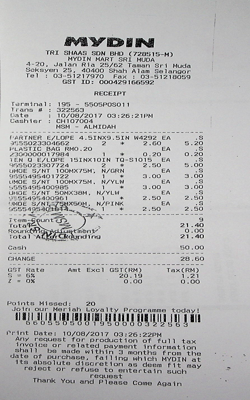

In [11]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))

Random sample is 96
OCR text is {"company": "POPULAR BOOK CO. (M) SDN BHD", "date": "29/03/18", "address": "NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA", "total": "9.65"}


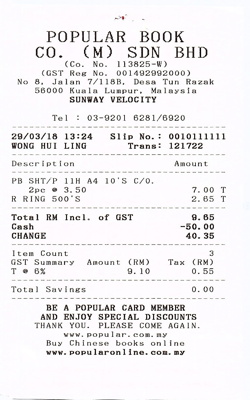

In [12]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))

Random sample is 121
OCR text is {"company": "SYARIKAT PERNIAGAAN GIN KEE", "date": "11/01/2018", "address": "NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.", "total": "21.20"}


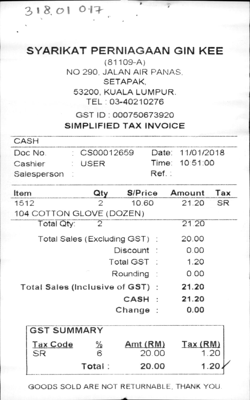

In [13]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))

# Prepare dataset for Donut

As we learned in the introduction, Donut is a sequence-to-sequence model with a vision encoder and text decoder. When fine-tuning the model we want it to generate the `"text"` based on the image we pass it. Similar to NLP tasks, we have to tokenize and preprocess the text. Before we can tokenize the text, we need to transform the JSON string into a Donut compatible document.

**Current JSON string**
```
{
  "company": "ADVANCO COMPANY",
  "date": "17/01/2018",
  "address": "NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR",
  "total": "7.00"
}

```
**Donut document**
```
<s></s><s_company>ADVANCO COMPANY</s_company><s_date>17/01/2018</s_date><s_address>NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR</s_address><s_total>7.00</s_total></s>

```

To easily create those documents, let's write a json2token method



In [14]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

In [15]:
proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


The next step is to tokenize our text and encode the images into tensors. Therefore we need to load `DonutProcessor`, add our new special tokens and adjust the size of the images when processing from `[1920, 2560]` to `[720, 960]` to need less memory and have faster training.



In [16]:
from transformers import DonutProcessor

# Load processor with the DonutProcessor's from pretrained method. Use the following repo: "naver-clova-ix/donut-base"
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [17]:
# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.image_processor.size = [720,960] # should be (width, height)
processor.image_processor.do_align_long_axis = False

Now, we can prepare our dataset, which we will use for the training later.



In [18]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

The last step is to split the dataset into train and validation sets. Use the "train_test_split" function and create a test size of 1/10th



In [21]:
processed_dataset = processed_dataset.train_test_split(test_size=float(1/10))
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 225
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 25
    })
})


# Fine-tune and evaluate Donut model

After we have processed our dataset, we can start training our model. Therefore we first need to load the [naver-clova-ix/donut-base](https://huggingface.co/naver-clova-ix/donut-base) model with the `VisionEncoderDecoderModel` class. The `donut-base` includes only the pre-trained weights and was introduced in the paper [OCR-free Document Understanding Transformer](https://arxiv.org/abs/2111.15664)by Geewok et al. and first released in this [repository](https://github.com/clovaai/donut).

In addition to loading our model, we are resizing the `embedding` layer to match newly added tokens and adjusting the `image_size` of our encoder to match our dataset. We are also adding tokens for inference later.

In [22]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model a VisionEncoderDecoderModel from a pretrained model on huggingface.co. You should use "naver-clova-ix/donut-base"
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

In [23]:
# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

New embedding size: Embedding(57533, 1024)


/usr/local/lib/python3.9/dist-packages/transformers/models/donut/processing_donut.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Before we can start our training we need to define the hyperparameters (`Seq2SeqTrainingArguments`) we want to use for our training. We are leveraging the [Hugging Face Hub ](https://huggingface.co/models)integration of the `Seq2SeqTrainer` to automatically push our checkpoints, logs and metrics during training into a repository.



In [24]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-sroie"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

In [30]:
# Create Seq2Seq Trainer object by passing the model, training args, and the train split fo our processed dataset
trainer = Seq2SeqTrainer(
    model=model
    ,args=training_args
    ,train_dataset=processed_dataset["train"]
    ,eval_dataset=processed_dataset["test"]
)

/content/donut-base-sroie is already a clone of https://huggingface.co/rjac/donut-base-sroie. Make sure you pull the latest changes with `repo.git_pull()`.


We can start our training by using the train method of the Seq2SeqTrainer.

In [31]:
# Start training
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,3.312700
200,0.992900
300,0.619400


TrainOutput(global_step=339, training_loss=1.5404728689728233, metrics={'train_runtime': 1122.5082, 'train_samples_per_second': 0.601, 'train_steps_per_second': 0.302, 'total_flos': 1.18724926749696e+18, 'train_loss': 1.5404728689728233, 'epoch': 3.0})

After our training is done we also want to save our processor to the Hugging Face Hub and create a model card.



In [32]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/772M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/1.24M [00:00<?, ?B/s]

Upload file runs/Mar23_17-04-40_f3a80a76a055/events.out.tfevents.1679591514.f3a80a76a055.1181.4:   0%|        …

To https://huggingface.co/rjac/donut-base-sroie
   aafa6eb..a3de791  main -> main

   aafa6eb..a3de791  main -> main



'https://huggingface.co/rjac/donut-base-sroie/commit/a3de79120a862b61dbd3fc1d036c13788b69c138'

# Evaluation

We sucessfully trained our model now lets test it and then evaulate accuracy of it.

In [33]:
# Load our model from Hugging Face '
model_base = "naver-clova-ix/donut-base"

In [34]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np

# hidde logs
transformers.logging.disable_default_handler()

processor = DonutProcessor.from_pretrained(model_base)
model = VisionEncoderDecoderModel.from_pretrained(model_base)

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 25)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Reference:
 {'total': '4.80', 'date': '14-03-2018', 'company': 'RESTORAN WAN SHENG', 'address': 'NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR'}
Prediction:
 {'text_sequence': '<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s> 0 0 0 0 0 0 0 0. Total Total Total Total 2 20 SR 2 x 2.20 0 0 0.20 Total QTY: 4 Total Total (Excluding GST Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total Total (Inclusive (6%): : (Inclusive (6%): : (Inclusive (%): 4300.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0 0.10442,0.646.646.646.646.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.

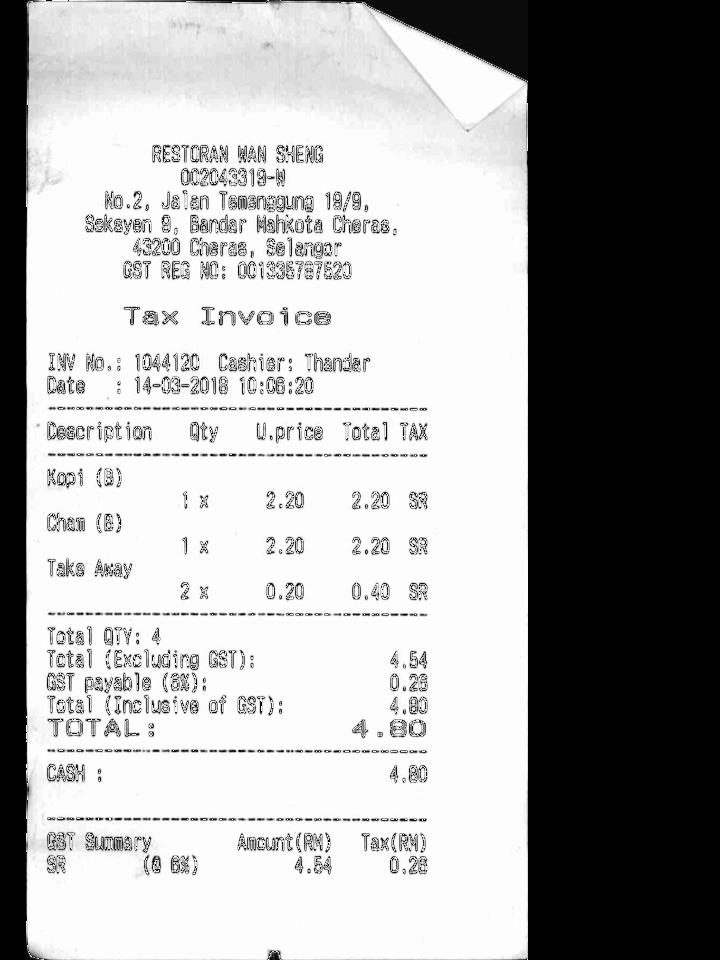

In [35]:
transformers.image_transforms.to_pil_image(np.array(test_sample["pixel_values"]), do_rescale=True)

Nice 😍🔥 Our fine-tuned parsed the document correctly and extracted the right values. Our next step is to evalute our model on the test set. Since the model itself is a seq2seq is not that straightforward to evaluate.

To keep things simple we will use accuracy as metric and compare the predicted value for each key in the dictionary to see if they are equal. This evaluation technique is biased/simple sincne only exact matches are truthy, e.g. if the model is not detecting a "whitespace" as in the example above it will not be counted truthy.

In [36]:
from tqdm import tqdm

# define counter for samples
true_counter = 0
total_counter = 0

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"Accuracy: {(true_counter/total_counter)*100}%")

100%|██████████| 25/25 [04:01<00:00,  9.65s/it]

Accuracy: 0.0%
